# AMADEUS CHALLENGE

### Introduction

The following challenge is conducted as part of the Kschool Master in Data Science. 

The challenge was created by Amadeus to asses the Data Science skills of candidates, and it consist in resolving three + two exercises given two files about flight bookings and searches. The exercises are:

- **First exercise:** count the number of lines of each file in Python
- **Second exercise:** identify the top 10 arrival airports in 2013
- **Third exercise:** plot the monthly number of searches or flights arriving at Madrid, Barcelona and Malaga
- **Bonus 1:** match searches with bookings and export results in a CSV file
- **Bonus 2:** write a web service


CLARIFICATION NOTE: first, second, third and bonus 1 exercises complede. bonus 2 exercise not. Documentation could be improved. 

In [1]:
#Get name of files and size
!ls -l --block-size=M ../

total 8041M
drwxrwxr-x 4 dsc dsc    1M jun  1 09:49 amadeus_challenge
-rw-rw-r-- 1 dsc dsc 4049M abr  2  2018 bookings.csv
-rw-rw-r-- 1 dsc dsc  405M jun  1 01:41 bookings_no_duplicates.csv
drwxrwxr-x 4 dsc dsc    1M may 31 18:10 Repo_challenge
-rw-rw-r-- 1 dsc dsc 3525M abr  2  2018 searches.csv
-rw-rw-r-- 1 dsc dsc   63M jun  1 01:40 searches_no_duplicates.csv


In [2]:
!cat ../bookings.csv | wc -l

10000011


In [3]:
!cat ../searches.csv | wc -l

20390198


The size of the files is too big to load it at once in memory, hence the files will need to be loaded as iterators.

In [4]:
#import libraries used
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import hashlib
import numpy as np

#Plot inside jupyter
%matplotlib inline

#Show all columns printing pandas objects
pd.options.display.max_columns = None


## Exercise 1: Count the number of lines in Python for each line

In [5]:
#Read files as iterator (due to memory constraints) with only one column to reduce the size of the file
bookings_reader=pd.read_csv("../bookings.csv", delimiter="^", iterator=True, chunksize = 10000, usecols=[0])
searches_reader=pd.read_csv("../searches.csv", delimiter="^", iterator=True, chunksize = 10000, usecols=[0])

In [6]:
#Function to calculate the length dataframe given its iterator
def file_lines (file):
    """Returns the length of a given file that has been read with the itereator"""
    length = 0
    for b_chunk in file:
        length += b_chunk.shape[0] #Adding the rows of each segment
    return length

In [7]:
bookings_len = file_lines(bookings_reader)
searches_len = file_lines(searches_reader)

In [8]:
print("Total lines of 'bookings.csv': {:,}".format(bookings_len))
print("Total lines of 'searches.csv': {:,}".format(searches_len))

Total lines of 'bookings.csv': 10,000,010
Total lines of 'searches.csv': 20,390,198


The total number of lines is:

- bookings.csv:  10000010 lines + header
- searches.csv: 20390198 lines + header


    

## Identifying and Cleaning Duplicates (if found)

To identify if there are duplicates, if we could load all the data into one DF we could call the methodn. duplicated() and check if there is any True value, however since we have to load the data into df chunks, it is possible that there are no duplicates within a chunk, but there are whithin different chunks.

For this reason, and since finding one duplicate means that there duplicates, we will follow this strategy to identify duplicates:

- First, we will check for duplicates using bash
- Then, we will check on Python. In python we will first check if we find duplicates within the first 20 chunks. If we find duplicates within the 20 first chunks, we will proceed remove them.

Clarification note: duplicates were identified performing bonus exercise one.

#### Checking duplicates in bash

In [9]:
#Unique lines (searches.csv)
!sort -u -t "^" ../searches.csv | wc -l

359005


In [10]:
#total lines (searches.csv)
!sort -t "^" ../searches.csv| wc -l

20390199


In [11]:
#Unique lines (bookings.csv)
!sort -u -t "^" ../bookings.csv | wc -l

1000004


In [12]:
#total lines (bookings.csv)
!sort -t "^" ../bookings.csv| wc -l

10000011


#### Now in Python

In [13]:
#Reading files with iterator
searches_reader=pd.read_csv("../searches.csv", 
                            delimiter="^", 
                            iterator=True, 
                            chunksize = 10000)
bookings_reader=pd.read_csv("../bookings.csv", 
                            delimiter="^", 
                            iterator=True, 
                            chunksize = 10000)

In [14]:
#Reading the first chunk of each file, and checking for duplicates
s_duplicate = False
b_duplicate = False
for i in range(0,20):
    s_chunk = searches_reader.get_chunk()
    b_chunk = bookings_reader.get_chunk()

    if True in s_chunk.duplicated().values:
        s_duplicate = True
    if True in b_chunk.duplicated().values:
        b_duplicate = True
        
print("Searches duplicates: {}".format(s_duplicate))
print("Bookings duplicates: {}".format(b_duplicate))

Searches duplicates: True
Bookings duplicates: False


Searching for duplicates within the chunks have resulted in identifying that searches.csv contains duplicates, and bookings.csv does not. However, as we explained before scoring True in this test proves that there are duplicates, but scoring False does not prove the opposite, is for this reason that both files will be treated for duplicates.

The method that we will be following is creating a hash table for each line in the files, and then iterating over the file, and creating a new file with only one occurrence of each hash as indicated by Stackoverlow user "zwer" in the following thread: https://stackoverflow.com/questions/52407474/removing-duplicates-on-very-large-datasets

In [15]:
def remove_duplicates (input_file,output_file):
    with open(input_file, "r") as f_in, \
            open(output_file, "w") as f_out:
        seen = set()  # a set to hold our 'visited' lines
        for line in f_in:  # iterate over the input file line by line
            line_hash = hashlib.md5(line.encode()).digest()  # hash the value
            if line_hash not in seen:  # we're seeing this line for the first time
                seen.add(line_hash)  # add it to the hash table
                f_out.write(line)  # write the line to the output

In [16]:
remove_duplicates("../searches.csv","../searches_no_duplicates.csv")

In [17]:
remove_duplicates("../bookings.csv","../bookings_no_duplicates.csv")

In [18]:
searches_lines_n_dup=file_lines(pd.read_csv("../searches_no_duplicates.csv", 
                            delimiter="^", 
                            iterator=True, 
                            chunksize = 10000))

In [19]:
bookings_lines_n_dup=file_lines(pd.read_csv("../bookings_no_duplicates.csv", 
                            delimiter="^", 
                            iterator=True, 
                            chunksize = 10000))

In [20]:
print("BOOKINGS.CSV \n------------")
print("Duplicated lines: {:10,}".format(bookings_len - bookings_lines_n_dup))
print("Total lines     : {:10,}".format(bookings_lines_n_dup))


print("\n\nSEARCHES.CSV \n------------")
print("Duplicated lines: {:10,}".format(searches_len - searches_lines_n_dup))
print("Total lines     : {:10,}".format(searches_lines_n_dup))


BOOKINGS.CSV 
------------
Duplicated lines:  9,000,007
Total lines     :  1,000,003


SEARCHES.CSV 
------------
Duplicated lines: 20,031,194
Total lines     :    359,004


It has been found file bookings.csv cointained 9M duplicates, and searches.csv 20M duplicates.

Therefore, the total number of lines is:
- bookings.csv: 1,000,003 + header
- searches.csv:   359,004 + header


*M- Million*

## Exercise 2: Top 10 arrivals  [no duplicates]

In [21]:
#Read file including only "arr_port" and "pax" to calculate top 10 airports
booking_reader=pd.read_csv("../bookings_no_duplicates.csv", usecols=["arr_port","pax"],delimiter="^", iterator=True, chunksize = 10000 )#names=[arr_port,pax]

In [22]:
#Read all the chuncks and group by arrival airport aggregating by bookings passangers ("pax")
pieces_bookings = [x.groupby("arr_port").sum() for x in booking_reader]

In [23]:
#Concatenate all the pieces
agg_bookings = pd.concat(pieces_bookings).groupby(level=0).sum()

In [24]:
#Reset index, strip the names, and assign back the index
agg_bookings.reset_index(inplace=True)
agg_bookings["arr_port"]=agg_bookings["arr_port"].str.strip()
agg_bookings.set_index("arr_port", inplace=True)
#print top 10 airports per number of passangers
agg_bookings.iloc[:,0].sort_values(ascending=False).head(10)

arr_port
LHR    8881.0
MCO    7093.0
LAX    7053.0
LAS    6963.0
JFK    6627.0
CDG    6449.0
BKK    5946.0
MIA    5815.0
SFO    5800.0
DXB    5559.0
Name: pax, dtype: float64

In [25]:
#Importing airport names from GeoBases selecting only columns iata_code, airport name and country name
url="https://raw.githubusercontent.com/opentraveldata/geobases/public/GeoBases/DataSources/Airports/GeoNames/airports_geonames_only_clean.csv"
columns=["iata_code","airport_name","country_name"]
iata_names = pd.read_csv(url, delimiter ="^",usecols=[0,1,4],header=None, names=columns)

#strip iata_codes and set as index
iata_names["iata_code"]=iata_names["iata_code"].str.strip()
iata_names.set_index("iata_code", inplace=True)

In [26]:
#merge files on idex to include names of country and airprt
agg_bookings_iata_names=agg_bookings.join(iata_names, how="left")

#print top 10 airports per number of passangers including airport name and country
agg_bookings_iata_names.sort_values(by="pax",ascending=False).head(10)

,pax,airport_name,country_name
arr_port,,,
LHR,8881.0,London Heathrow Airport,United Kingdom
MCO,7093.0,Orlando International Airport,United States
LAX,7053.0,Los Angeles International Airport,United States
LAS,6963.0,McCarran International Airport,United States
JFK,6627.0,John F Kennedy International Airport,United States
CDG,6449.0,Paris - Charles-de-Gaulle,France
BKK,5946.0,Suvarnabhumi,Thailand
MIA,5815.0,Miami International Airport,United States
SFO,5800.0,San Francisco International Airport,United States


## THIRD EXERCISE: plot the monthly number of searches for flights arriving at Malaga, Madrid or Barcelona. [no duplicates]

Plot one curve for Malaga, another for Madrid and another for Barcelona in the same fig.

In [27]:
#Explore searches file to select only relevant columns
searches_reader=pd.read_csv("../searches_no_duplicates.csv", delimiter="^", iterator=True, chunksize = 10000)
searches_df=searches_reader.get_chunk()

In [28]:
searches_df.head()

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL


In [33]:
#Select Relevant columns
relevant_columns=["Date","Destination"]

#Import only relevant columns, merging dates and parsing it to datetime
searches_df=pd.read_csv("../searches_no_duplicates.csv", 
                            delimiter="^", 
                            usecols=relevant_columns)



#Explore the type of the columns
searches_df.info()
searches_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359004 entries, 0 to 359003
Data columns (total 2 columns):
Date           359004 non-null object
Destination    359003 non-null object
dtypes: object(2)
memory usage: 5.5+ MB


,Date,Destination
0,2013-01-01,AUH
1,2013-01-01,MIL
2,2013-01-01,SFO
3,2013-01-01,ARN
4,2013-01-01,MAD


In [35]:
#Clean destination file & Filtering Madrid (MAD), Barcelona(BCN) & Malaga(AGP)
searches_df["Destination"] = searches_df["Destination"].str.strip()
query= (searches_df["Destination"]=="MAD") | (searches_df["Destination"]=="BCN") | (searches_df["Destination"]=="AGP")
searches_esp= searches_df[query].copy()

#Convert dates to datetime
searches_esp["Date"] = pd.to_datetime(searches_esp["Date"])

In [36]:
to_plot = searches_esp[searches_esp["Destination"]=="MAD"].resample("M", on="Date").count()
to_plot["Date"]

Date
2013-01-31    425
2013-02-28    400
2013-03-31    433
2013-04-30    443
2013-05-31    462
2013-06-30    400
2013-07-31    403
2013-08-31    383
2013-09-30    371
2013-10-31    395
2013-11-30    362
2013-12-31    259
Freq: M, Name: Date, dtype: int64

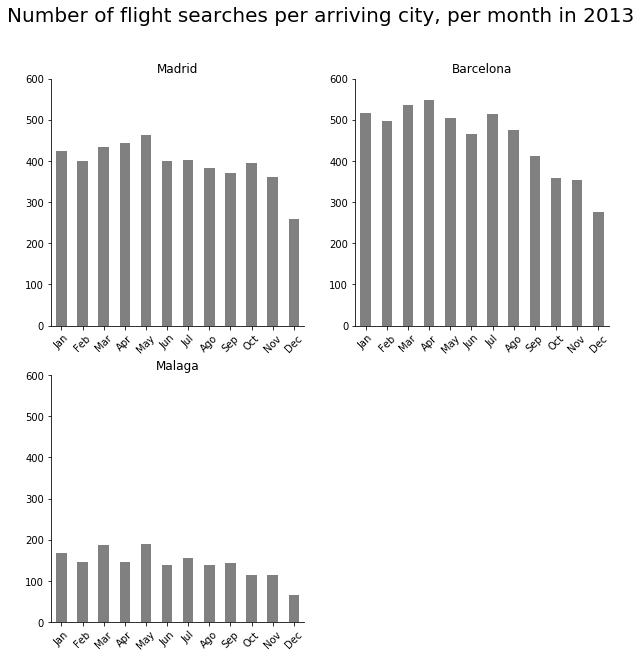

In [37]:
airports = {"MAD":"Madrid","BCN":"Barcelona","AGP":"Malaga"}
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dec"]

#Create figure
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Number of flight searches per arriving city, per month in 2013', fontsize=20)

#Aggregate and plot
for i,air in enumerate(airports):
    ax = fig.add_subplot(2,2,i+1)
    to_plot = searches_esp[searches_esp["Destination"]==air].resample("M", on="Date").count()
    to_plot["Date"].plot(kind="bar",ax=ax, title=airports[air], rot=45, color="grey", legend=None)
    ax.set_xticklabels(months)
    ax.xaxis.set_label_text("")
    ax.set_ylim(0,600)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

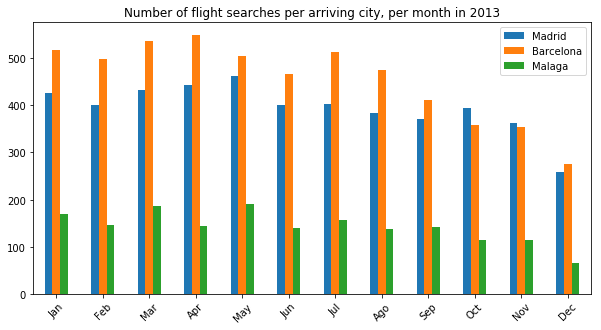

In [40]:
new = pd.DataFrame()
for i,air in enumerate(airports):
    to_plot = searches_esp[searches_esp["Destination"]==air].resample("M", on="Date").count()["Destination"]
    new[airports[air]]=to_plot
    
new.index=months
new.plot(kind="bar",figsize=(10,5), rot=45, title = "Number of flight searches per arriving city, per month in 2013")


## BONUS EXERCISE: match searches with bookings [no duplicates]

For every search in the searches file, find out whether ended up in a booking or not.
Generate a csv with the searches with an additional column containing 1 if the search ended up in a booking or 0 in any other case.

origin and destination in the search should match with the booking

Process:
1. Identify relevant columns to from both files.
2. Add a column with "1"s to bookings df
3. Left join bookings into searches by the columns identifiedin step 1
4. Assign 0 to "NaN"s on the new column 

### Identify columns to compare in both files.

First, since we dont have a column description file, lets explore the data again and try to identify common columns in both files. Intuition suggest that we will need to find matching flight details, and date, since the same flight can occure multiple times a year.

In [41]:
#Reading the files with iterator
booking_reader=pd.read_csv("../bookings_no_duplicates.csv", 
                            delimiter="^",
                            iterator = True,
                            chunksize = 1000)

searches_reader=pd.read_csv("../searches_no_duplicates.csv", 
                            delimiter="^",
                            iterator = True,
                            chunksize = 1000)

#Reading the first block of the files
booking_chunk = booking_reader.get_chunk()
searches_chunk = searches_reader.get_chunk()

In [42]:
#Cleaning the columns from whitespaces before and after for bookings
booking_chunk.columns=booking_chunk.columns.str.strip()

In [43]:
booking_chunk.head()

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,dep_city,dep_ctry,arr_port,arr_city,arr_ctry,lst_port,lst_city,lst_ctry,brd_port,brd_city,brd_ctry,off_port,off_city,off_ctry,mkt_port,mkt_city,mkt_ctry,intl,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-03-05 00:00:00,1A,DE,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,2013-02-22 00:00:00,1708,0,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHRZRH,LONZRH,CHGB,1,LHRZRH,VI,T,Y,2013-03-07 08:50:00,2013-03-07 11:33:37,-1,2013,3,NULL
1,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,SAL,SAL,SV,CLT,CLT,US,CLTSAL,CLTSAL,SVUS,1,SALATLCLT,NV,L,Y,2013-04-12 13:04:00,2013-04-12 22:05:40,1,2013,3,NULL
2,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,CLTSAL,CLTSAL,SVUS,1,CLTATLSAL,NV,U,Y,2013-07-15 07:00:00,2013-07-15 11:34:51,1,2013,3,NULL
3,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,AKL,AKL,NZ,SVO,MOW,RU,AKLSVO,AKLMOW,NZRU,1,AKLHKGSVO,XK,G,Y,2013-04-24 23:59:00,2013-04-25 16:06:31,1,2013,3,SYDA82546
4,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,AKLSVO,AKLMOW,NZRU,1,SVOHKGAKL,XK,G,Y,2013-05-14 20:15:00,2013-05-16 10:44:50,1,2013,3,SYDA82546


Columns that may be interesting from bookings.csv file:

Flight relate columns:
- **dep_port**: departure airport
- **arr_port**: arrival airport
- **mkt_port**: ?
- **route**: Starting airport to arrival airport, including transfer airport - one way
- **carrier**: airline
- **lst_port**: returning airpot
- **brd_port**: ?
- **off_port**: ?


Date related columns:
- **act_date**: unknown
- **cre_date**: creation date - when the booking is performed ?
- **brd_time**: boarding time?
- **off_time**: arrival time?

In [44]:
searches_chunk.head()

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL


Columns that may be interesting from searches.csv file:

Flight relate columns:
- **Origin**: departure airport
- **Destination**: arrival airport
- **SegXDeparture**: departure airport per segment
- **SegXArrival**: arrival airport per segment
- **SegXCarrier**: airline of the segment

Date related columns:
- **Date**: search date
- **Time**: search time
- **SegXDate**: time of the flight per segment

It seems that file searches.csv contains additional detail to bookings.csv; it seems to include all the intermediary transfers, including return details. 

- Does this mean that a return-flight search could create two booking lines? 

#### Matching possibilities:
- For FLIGHT data
    - "Origin" (searches.csv) seems to have a direct match with "dep_port" (bookings.csv)
    - "Destination" (searches.csv) seems to have a direct match with "arr_port" (bookings.csv)
    - "route" seems to be the combination of all "segXDeparture" (bookings.csv) excluding return segments. 
    - "carrier" seems to be related with "SegXCarrier" however, when there are multiple segments in the searches.csv file, there could be multiple carriers and it is not clear which airline could corresponde to the carrier in the bookings.csv file. 
    
- For DATE data (more confusing)
    - "Date" (searches.csv) could be related to "cre_date", but its not clear 
    - "SegXDate" could be related to "brd_time", but its not clear.
    
**Matching possibilities for the flight, are clear. However, without a matching date, any route search would create a booking possitive to all the bookings with the same route / Origin & Destination, depending on the matching strategy.**

Lets do additional research to confirm what dates match:

In [45]:
#Reading complete files without duplicates
booking_df=pd.read_csv("../bookings_no_duplicates.csv", 
                            delimiter="^")

searches_df=pd.read_csv("../searches_no_duplicates.csv", 
                            delimiter="^")

/home/dsc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7,8,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/dsc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (40,41,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:
#Cleaning the columns from whitespaces before and after for bookings
booking_df.columns=booking_chunk.columns.str.strip()

In [47]:
booking_df["route"].value_counts()[-10:]

PTPORYLDE             1
FRAIAHGDL             1
DOHCGK                1
DTWCLTPHF             1
FCOTSRBCM             1
MUCFRAPHL             1
BHSSYD                1
HKGNRTATLFWA          1
LAXLHRALG             1
YEGMSPMKE             1
Name: route, dtype: int64

Lets select RHOLED, which should be easy to find in searches.csv, if it exists.

In [48]:
booking_df[booking_df["route"].str.strip()=="RHOLED"]

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,dep_city,dep_ctry,arr_port,arr_city,arr_ctry,lst_port,lst_city,lst_ctry,brd_port,brd_city,brd_ctry,off_port,off_city,off_ctry,mkt_port,mkt_city,mkt_ctry,intl,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
988255,2013-10-02 00:00:00,1A,RU,b185051a3f3911a3ad98fd3f32195278,3d06ccaeeb56bf2cd83921dcea0e50e8,6bf56f19cb450c7d378c887e27f64e8f,2013-10-02 00:00:00,231,2604,RHO,RHO,GR,LED,LED,RU,LED,LED,RU,RHO,RHO,GR,LED,LED,RU,LEDRHO,LEDRHO,GRRU,1,RHOLED,KV,S,Y,2013-10-05 06:00:00,2013-10-05 10:51:50,4.0,2013.0,10.0,NULL


In [49]:
searches_df[(searches_df["Origin"]=="RHO")&(searches_df["Destination"]=="LED")]

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
206794,2013-07-26,05:53:10,MPT,d03a30f66f773a65aad66e7bafd1110f,GR,RHO,LED,0.0,1.0,RHO,LED,2013-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0


We were semi-lucky!, we found a matched record, however... none of the dates match... This could mean two things:
- The search does not correspond to the booking.
- We dont have enough information to match both files by DATE.

And without a "readme" file with information about the columns, we would need to continue researching until we find a match, or we conclude that there is not a direct match between date.

**Since this is a theoretical exercise, lets merege the files by:**
- **"Origin"(searches.csv) == "dep_port" (bookings.csv)**
- **"Destination" (searches.csv) == "arr_port" (bookings.csv)**
- **"Date" (searches.csv) == "cre_date" (bookings.csv)**

### Preparing data for merging

In [50]:
#Reading
booking_df=pd.read_csv("../bookings_no_duplicates.csv", 
                            delimiter="^",
                            usecols=["arr_port","dep_port","cre_date           "])

searches_df=pd.read_csv("../searches_no_duplicates.csv", 
                            delimiter="^",
                            usecols=["Origin","Destination","Date"])

In [51]:
booking_df.columns=booking_df.columns.str.strip()

In [52]:
# Formatting date column
def to_date (x):
    if len(x)==10:
        return x
    elif len(x)>10:
        return x[0:10]
    else:
        return np.nan

booking_df["cre_date"]=booking_df["cre_date"].map(to_date)
searches_df["Date"]=searches_df["Date"].map(to_date)

In [53]:
# Finding Nan
print("NaN in bookings: {}".format(booking_df.isnull().sum().sum()))
print("NaN in searches: {}".format(searches_df.isnull().sum().sum()))

NaN in bookings: 1
NaN in searches: 2


Bookings has no NaN, however searches contains 2 NaN

In [54]:
#Select rows with NAN
print(searches_df[searches_df.isnull().any(axis=1)])
print(booking_df[booking_df.isnull().any(axis=1)])

              Date Origin Destination
359000  2013-01-01    NaN         NaN
        cre_date  dep_port  arr_port
1000001      NaN  JP        SG      


In [55]:
#Since is only one, and doesnt contain nor Oriign nor Destiantion, we can safely drop it 
searches_df.dropna(inplace=True)
booking_df.dropna(inplace=True)

In [56]:
#strip columns
booking_df["arr_port"]=booking_df["arr_port"].str.split().astype(str)
booking_df["dep_port"]=booking_df["dep_port"].str.split().astype(str)
searches_df["Origin"]=searches_df["Origin"].str.split().astype(str)
searches_df["Destination"]=searches_df["Destination"].str.split().astype(str)

In [57]:
#Removing duplicates in bookings to keep shape whem merging with searches
booking_df.drop_duplicates(inplace=True)

In [58]:
booking_df["booked"]=1

### Merging bookings and searches

In [59]:
#Merging booking to searches
merged = pd.merge(searches_df,booking_df, how="left",left_on=["Origin","Destination","Date"], right_on=["dep_port","arr_port","cre_date"])

In [60]:
merged["booked"].fillna(0,inplace=True)
merged["booked"]=merged["booked"].astype(int)

In [61]:
merged["booked"].value_counts(dropna=False)

0    346225
1     12778
Name: booked, dtype: int64

Using the selected matching strategy, out of the 359,003 unique lines inside searches.csv, 12.778 created a booking.

It is important to note that the filteres used were:

- "Origin"(searches.csv) == "dep_port" (bookings.csv)
- "Destination" (searches.csv) == "arr_port" (bookings.csv)
- "Date" (searches.csv) == "cre_date" (bookings.csv)

Lets complete the exercise by merging searches column "booked" to the complete searches.csv (without duplicates), and saving it to csv:

In [62]:
#Read complete file seraches-csv
searches_df_all_columns=pd.read_csv("../searches_no_duplicates.csv", 
                            delimiter="^")

In [63]:
#merge booked column to searches
searches_df_all_columns["booked"]=merged["booked"]

In [64]:
#print first rows of the merged file
searches_df_all_columns.head()

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice,booked
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1.0,2.0,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA,0.0
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0.0,1.0,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV,0.0
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1.0,2.0,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC,0.0
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0.0,1.0,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO,0.0
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1.0,2.0,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL,0.0


In [65]:
#Export to file
searches_df_all_columns.to_csv("searches_2.csv")

In [66]:
ll

total 68804
-rw-rw-r-- 1 dsc    89829 jun  1 10:05 amadeus_challenge.ipynb
-rw-rw-r-- 1 dsc       38 may 27 22:08 README.md
-rw-rw-r-- 1 dsc 70351826 jun  1 10:06 searches_2.csv
-rw-rw-r-- 1 dsc     2966 may 31 19:40 Tests.ipynb
-rw-rw-r-- 1 dsc       72 jun  1 09:24 Untitled.ipynb


Finally, merged results are saved into searches_2.csv